In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from dataclasses import dataclass
from pathlib import Path
import yaml

from omegaconf import OmegaConf, DictConfig
import pandas as pd
from matplotlib import transforms
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import torch
from tqdm.auto import tqdm

from src.analysis.state_space import StateSpaceAnalysisSpec
from src.analysis.trf import coefs_to_df
from src.encoding.ecog.timit import OutFile
from src.encoding.ecog import timit as timit_encoding, get_electrode_df, \
     AlignedECoGDataset, ContrastiveModelSnapshot, epoch_by_state_space
from src.viz.epoching import plot_epoch_raster

In [7]:
dataset = "timit"
subject = "EC260"
ttest_results_path = f"outputs/encoder_comparison_across_subjects/{dataset}/ttest.csv"
scores_path = f"outputs/encoder_comparison_across_subjects/{dataset}/scores.csv"
encoder_dirs = list(Path("outputs/encoders").glob(f"{dataset}/*/{subject}"))

pval_threshold = 1e-3

In [8]:
scores_df = pd.read_csv(scores_path, index_col=["dataset", "subject", "model2", "model1"]).loc[dataset, subject]
scores_df

/tmp/ipykernel_2687787/1227382919.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  scores_df = pd.read_csv(scores_path, index_col=["dataset", "subject", "model2", "model1"]).loc[dataset, subject]


electrode_name  \
model2                             model1                    
phoneme                            baseline            FG1   
                                   baseline            FG1   
                                   baseline            FG1   
                                   baseline            FG2   
                                   baseline            FG2   
...                                                    ...   
word_broad-aniso3-w2v2_8-meanlast5 baseline          TG127   
                                   baseline          TG127   
                                   baseline          TG128   
                                   baseline          TG128   
                                   baseline          TG128   

                                                                          model  \
model2                             model1                                         
phoneme                            baseline                            baseline   
                                   baseline                            baseline   
                                   baseline                            baseline   
                                   baseline                            baseline   
                                   baseline                            baseline   
...                                                                         ...   
word_broad-aniso3-w2v2_8-meanlast5 baseline  word_broad-aniso3-w2v2_8-meanlast5   
                                   baseline  word_broad-aniso3-w2v2_8-meanlast5   
                                   baseline  word_broad-aniso3-w2v2_8-meanlast5   
                                   baseline  word_broad-aniso3-w2v2_8-meanlast5   
                                   baseline  word_broad-aniso3-w2v2_8-meanlast5   

                                             output_dim  fold     score  \
model2                             model1                                 
phoneme                            baseline           0     0 -0.000562   
                                   baseline           0     1  0.000061   
                                   baseline           0     2 -0.000027   
                                   baseline           1     0 -0.004349   
                                   baseline           1     1 -0.001013   
...                                                 ...   ...       ...   
word_broad-aniso3-w2v2_8-meanlast5 baseline         254     1  0.059772   
                                   baseline         254     2  0.047748   
                                   baseline         255     0  0.076197   
                                   baseline         255     1  0.054346   
                                   baseline         255     2  0.046501   

                                                output_name  
model2                             model1                    
phoneme                            baseline      (0, 'FG1')  
                                   baseline      (0, 'FG1')  
                                   baseline      (0, 'FG1')  
                                   baseline      (1, 'FG2')  
                                   baseline      (1, 'FG2')  
...                                                     ...  
word_broad-aniso3-w2v2_8-meanlast5 baseline  (254, 'TG127')  
                                   baseline  (254, 'TG127')  
                                   baseline  (255, 'TG128')  
                                   baseline  (255, 'TG128')  
                                   baseline  (255, 'TG128')  

[33792 rows x 6 columns]

In [9]:
ttest_df = pd.read_csv(ttest_results_path, index_col=["dataset", "subject", "model2", "model1", "output_dim"]).loc[dataset, subject]
ttest_df["log_pval"] = np.log10(ttest_df["pval"])
ttest_df

/tmp/ipykernel_2687787/294281794.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  ttest_df = pd.read_csv(ttest_results_path, index_col=["dataset", "subject", "model2", "model1", "output_dim"]).loc[dataset, subject]


Unnamed: 4  \
model2                             model1   output_dim               
phoneme                            baseline 206                  0   
                                            237                  1   
                                            221                  2   
                                            190                  3   
                                            222                  4   
...                                                            ...   
word_broad-aniso3-w2v2_8-meanlast5 baseline 218                 95   
                                            187                 96   
                                            164                 97   
                                            114                 98   
                                            218                 99   

                                                       permutation  \
model2                             model1   output_dim               
phoneme                            baseline 206              shift   
                                            237              shift   
                                            221              shift   
                                            190              shift   
                                            222              shift   
...                                                            ...   
word_broad-aniso3-w2v2_8-meanlast5 baseline 218              units   
                                            187              shift   
                                            164              shift   
                                            114              shift   
                                            218              shift   

                                                              tval  \
model2                             model1   output_dim               
phoneme                            baseline 206         572.531062   
                                            237         100.138465   
                                            221          63.335976   
                                            190          57.373202   
                                            222          55.419492   
...                                                            ...   
word_broad-aniso3-w2v2_8-meanlast5 baseline 218           1.864123   
                                            187           1.694180   
                                            164          -1.582921   
                                            114          -0.482354   
                                            218          -0.275392   

                                                                pval  \
model2                             model1   output_dim                 
phoneme                            baseline 206         5.584010e-11   
                                            237         5.962918e-08   
                                            221         3.722442e-07   
                                            190         5.526318e-07   
                                            222         6.346861e-07   
...                                                              ...   
word_broad-aniso3-w2v2_8-meanlast5 baseline 218         1.357510e-01   
                                            187         1.654800e-01   
                                            164         1.886070e-01   
                                            114         6.547617e-01   
                                            218         7.966560e-01   

                                                         log_pval  
model2                             model1   output_dim             
phoneme                            baseline 206        -10.253054  
                                            237         -7.224541  
                                            221         -6.429172  
                                            19

In [10]:
ttest_filtered_df = ttest_df.dropna().sort_values("pval", ascending=False) \
    .groupby(["model2", "output_dim"]).first()
ttest_filtered_df = ttest_filtered_df.loc[ttest_filtered_df["pval"] < pval_threshold]
ttest_filtered_df

Unnamed: 4 permutation       tval          pval  \
model2            output_dim                                                    
biphone_pred      94                  12       shift   9.419015  7.082382e-04   
                  190                  2       shift  34.390189  4.265489e-06   
                  191                  7       shift  14.406890  1.349113e-04   
                  202                 14       shift   8.672717  9.727148e-04   
                  204                  6       shift  17.059658  6.924469e-05   
...                                  ...         ...        ...           ...   
word_broad-w2v2_8 205                 13       units  12.543839  2.324071e-04   
                  206                  1       shift  95.770972  7.126890e-08   
                  220                 12       units  13.430998  1.777609e-04   
                  237                 15       shift  11.992107  2.771406e-04   
                  247                 19       units   9.643843  6.466122e-04   

                              log_pval  
model2            output_dim            
biphone_pred      94         -3.149821  
                  190        -5.370031  
                  191        -3.869952  
                  202        -3.012014  
                  204        -4.159614  
...                                ...  
word_broad-w2v2_8 205        -3.633751  
                  206        -7.147100  
                  220        -3.750164  
                  237        -3.557300  
                  247        -3.189356  

[259 rows x 5 columns]

In [11]:
encoder_dirs = [Path(p) for p in encoder_dirs]
encoder_dirs = {encoder_dir.parent.name: encoder_dir for encoder_dir in encoder_dirs}
encoders = {model_name: torch.load(encoder_dir / "model.pkl")
            for model_name, encoder_dir in encoder_dirs.items()}
encoder_names = sorted(encoders.keys())

In [12]:
baseline_scores = pd.read_csv(encoder_dirs["baseline"] / "scores.csv")

In [13]:
# Just need a random config in order to extract relevant paths and get outfile
sample_model_path = encoder_dirs["phoneme"]
with (sample_model_path / ".hydra" / "config.yaml").open() as f:
    model_config = OmegaConf.create(yaml.safe_load(f))
out = timit_encoding.prepare_out_file(model_config, next(iter(model_config.data)))

In [14]:
snapshot = ContrastiveModelSnapshot.from_config(model_config, next(iter(model_config.feature_sets.model_features.values())))

In [15]:
aligned = AlignedECoGDataset(snapshot, out)

Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

In [16]:
electrode_df = pd.read_csv(next(iter(encoder_dirs.values())) / "electrodes.csv")
electrode_df

electrode_idx electrode_name     long_name   type  \
0                0            FG1  FrontalGrid1   grid   
1                1            FG2  FrontalGrid2   grid   
2                2            FG3  FrontalGrid3   grid   
3                3            FG4  FrontalGrid4   grid   
4                4            FG5  FrontalGrid5   grid   
..             ...            ...           ...    ...   
313            313            ID6       Insula6  depth   
314            314            ID7       Insula7  depth   
315            315            ID8       Insula8  depth   
316            316            ID9       Insula9  depth   
317            317           ID10      Insula10  depth   

                              roi  
0                parstriangularis  
1                parstriangularis  
2                parstriangularis  
3                 parsopercularis  
4                 parsopercularis  
..                            ...  
313    Left-Cerebral-White-Matter  
314  ctx_lh_S_precentral-inf-part  
315  ctx_lh_S_precentral-inf-part  
316    Left-Cerebral-White-Matter  
317         ctx_lh_G_front_middle  

[318 rows x 5 columns]

In [17]:
num_fit_electrodes = next(iter(encoders.values())).coef_.shape[0]
electrode_names = electrode_df.head(num_fit_electrodes).electrode_name
coef_dfs = {model_name: coefs_to_df(torch.load(encoder_dir / "coefs.pkl"),
                                    encoders[model_name].feature_names,
                                    electrode_names,
                                    encoders[model_name].sfreq)
            for model_name, encoder_dir in tqdm(encoder_dirs.items())}
coef_df = pd.concat(coef_dfs, names=["model"]).droplevel(1)
coef_df

  0%|          | 0/23 [00:00<?, ?it/s]

fold            feature output_name  input_dim  \
model                                                                  
biphone_recon-w2v2_8     0              onset         FG1          0   
biphone_recon-w2v2_8     0              onset         FG1          0   
biphone_recon-w2v2_8     0              onset         FG1          0   
biphone_recon-w2v2_8     0              onset         FG1          0   
biphone_recon-w2v2_8     0              onset         FG1          0   
...                    ...                ...         ...        ...   
word_broad-aniso1        2  model_embedding_7       TG128         20   
word_broad-aniso1        2  model_embedding_7       TG128         20   
word_broad-aniso1        2  model_embedding_7       TG128         20   
word_broad-aniso1        2  model_embedding_7       TG128         20   
word_broad-aniso1        2  model_embedding_7       TG128         20   

                      output_dim  lag  time      coef  
model                                                  
biphone_recon-w2v2_8           0    0  0.00  0.000041  
biphone_recon-w2v2_8           0    1  0.01  0.000078  
biphone_recon-w2v2_8           0    2  0.02 -0.000084  
biphone_recon-w2v2_8           0    3  0.03 -0.000058  
biphone_recon-w2v2_8           0    4  0.04 -0.000039  
...                          ...  ...   ...       ...  
word_broad-aniso1            255   56  0.56 -0.000059  
word_broad-aniso1            255   57  0.57 -0.000014  
word_broad-aniso1            255   58  0.58 -0.000034  
word_broad-aniso1            255   59  0.59 -0.000174  
word_broad-aniso1            255   60  0.60 -0.000227  

[21315840 rows x 8 columns]

In [18]:
all_trf_features = coef_df.feature.unique()
all_trf_features

array(['onset', 'phnfeatConsOnset_0', 'phnfeatConsOnset_1',
       'phnfeatConsOnset_2', 'phnfeatConsOnset_3', 'phnfeatConsOnset_4',
       'phnfeatConsOnset_5', 'maxDtL', 'formantMedOnset_0',
       'formantMedOnset_1', 'formantMedOnset_2', 'formantMedOnset_3',
       'F0', 'model_embedding_0', 'model_embedding_1',
       'model_embedding_2', 'model_embedding_3', 'model_embedding_4',
       'model_embedding_5', 'model_embedding_6', 'model_embedding_7'],
      dtype=object)

In [19]:
phonetic_features = [f"phnfeatConsOnset_{i}" for i in range(6)]
phonetic_features += [f"formantMedOnset_{i}" for i in range(4)]

### Compute epoched HGA

In [20]:
# hack together a new state space spec for sentence onset
# nb state space bounds are inclusive, so we need to subtract 1 from the end of each bound
trial_spec = StateSpaceAnalysisSpec(
    aligned.total_num_frames,
    ["trial"],
    [sorted([(start, end - 1) for start, end in aligned.name_to_frame_bounds.values()])],
)
aligned._snapshot.all_state_spaces["trial"] = trial_spec

In [21]:
trial_epochs = epoch_by_state_space(
    aligned, "trial",
    epoch_window=(-0.1, 1.),
    baseline_window=(-0.1, 0.),
    return_df=True)
trial_epochs.head(3)

  0%|          | 0/499 [00:00<?, ?it/s]

epoch_idx  electrode_idx epoch_sample     value epoch_time epoch_label  \
0          0              0            0  0.361980       -0.1       trial   
1          0              1            0 -0.108401       -0.1       trial   
2          0              2            0 -0.028255       -0.1       trial   

   epoch_duration_samples          name  item_idx  trial_idx state_space  \
0                     110  fadg0_si1279      5252          0       trial   
1                     110  fadg0_si1279      5252          0       trial   
2                     110  fadg0_si1279      5252          0       trial   

   label_idx  instance_idx                  span_secs span_model_frames  \
0          0           426  (0.0, 1.7974291666666669)           (0, 89)   
1          0           426  (0.0, 1.7974291666666669)           (0, 89)   
2          0           426  (0.0, 1.7974291666666669)           (0, 89)   

  span_ecog_samples span_ecog_samples_nopad  item_start_frame  item_end_frame  \
0         (50, 229)                (0, 179)            803496          803586   
1         (50, 229)                (0, 179)            803496          803586   
2         (50, 229)                (0, 179)            803496          803586   

   epoch_duration_secs  
0                  1.1  
1                  1.1  
2                  1.1

In [22]:
assert trial_epochs.groupby(["epoch_idx", "electrode_idx", "epoch_sample"]).value.count().max() == 1

In [23]:
word_epochs = epoch_by_state_space(
    aligned, "word",
    epoch_window=(-0.1, 0.6),
    baseline_window=(-0.1, 0.),
    return_df=True)

  0%|          | 0/3052 [00:00<?, ?it/s]

In [24]:
word_freq_df = pd.read_csv("data/SUBTLEXus74286wordstextversion.txt", sep="\t", index_col=0)

word_metadata = snapshot.all_state_spaces["word"].cuts.xs("syllable", level="level") \
    .groupby(["label", "instance_idx"]).description.count().rename("num_syllables") \
    .reset_index()
word_metadata["monosyllabic"] = word_metadata.num_syllables == 1
word_metadata["word_frequency"] = word_metadata.label.map(word_freq_df.FREQcount) \
    .fillna(np.percentile(word_freq_df.FREQcount, 2))
print("Word frequency tertile split:\n", word_metadata.word_frequency.quantile([0.33, 0.66]))
word_metadata["word_frequency_quantile"] = pd.qcut(word_metadata.word_frequency, 3, labels=["low", "med", "high"])
print(word_metadata.groupby("word_frequency_quantile").apply(lambda xs: xs.sample(5).label))
word_metadata

Word frequency tertile split:
 0.33      1679.0
0.66    108306.0
Name: word_frequency, dtype: float64
word_frequency_quantile       
low                      6733     barriers
                         13846       don't
                         47720        tube
                         33231       pairs
                         36113     removal
med                      1613        after
                         17012        from
                         18711       great
                         44889       these
                         49311        wash
high                     37656         she
                         53319         you
                         3886          and
                         24152          is
                         17912        good
Name: label, dtype: object


/tmp/ipykernel_2687787/3075667448.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(word_metadata.groupby("word_frequency_quantile").apply(lambda xs: xs.sample(5).label))


label  instance_idx  num_syllables  monosyllabic  word_frequency  \
0       'em             0              1          True             1.0   
1       'em             1              1          True             1.0   
2       'em             2              1          True             1.0   
3       'em             3              1          True             1.0   
4       'em             4              1          True             1.0   
...     ...           ...            ...           ...             ...   
54352  zoos             2              1          True            39.0   
54353  zoos             3              1          True            39.0   
54354  zoos             4              1          True            39.0   
54355  zoos             5              1          True            39.0   
54356  zoos             6              1          True            39.0   

      word_frequency_quantile  
0                         low  
1                         low  
2                         low  
3                         low  
4                         low  
...                       ...  
54352                     low  
54353                     low  
54354                     low  
54355                     low  
54356                     low  

[54357 rows x 6 columns]

In [25]:
# Merge in word metadata
word_epochs = pd.merge(
    word_epochs, word_metadata,
    left_on=["epoch_label", "instance_idx"],
    right_on=["label", "instance_idx"],
    how="left",
    validate="many_to_one")

In [26]:
word_epochs.head(3)

epoch_idx  electrode_idx epoch_sample     value epoch_time epoch_label  \
0          0              0            0  0.005332       -0.1      bricks   
1          0              1            0  0.702084       -0.1      bricks   
2          0              2            0 -0.425304       -0.1      bricks   

   epoch_duration_samples          name  item_idx  trial_idx  ...  \
0                      70  fadg0_si1279      5252          0  ...   
1                      70  fadg0_si1279      5252          0  ...   
2                      70  fadg0_si1279      5252          0  ...   

  span_ecog_samples  span_ecog_samples_nopad  item_start_frame item_end_frame  \
0          (62, 94)                 (12, 44)            803496         803586   
1          (62, 94)                 (12, 44)            803496         803586   
2          (62, 94)                 (12, 44)            803496         803586   

  epoch_duration_secs   label num_syllables  monosyllabic  word_frequency  \
0                 0.7  bricks             1          True           200.0   
1                 0.7  bricks             1          True           200.0   
2                 0.7  bricks             1          True           200.0   

   word_frequency_quantile  
0                      low  
1                      low  
2                      low  

[3 rows x 25 columns]

In [27]:
syllable_epochs = epoch_by_state_space(
    aligned, "syllable",
    epoch_window=(-0.1, 0.3),
    baseline_window=(-0.1, 0.),
    return_df=True)

  0%|          | 0/4120 [00:00<?, ?it/s]

### Plotting prep

In [28]:
model_color_norm = plt.Normalize(0, len(encoder_names))
model_color_mapper = plt.colormaps["tab10"]
get_model_color = lambda model_name: model_color_mapper(model_color_norm(encoder_names.index(model_name)))

### Correspondences between electrodes significant under different models

In [29]:
log_pvals = ttest_filtered_df.pivot_table(values="log_pval", index="model2", columns="output_dim").fillna(0)
log_pvals

output_dim                               6         12        29        45   \
model2                                                                       
biphone_pred                        0.000000  0.000000  0.000000  0.000000   
biphone_pred-w2v2_8                 0.000000  0.000000  0.000000  0.000000   
biphone_recon                       0.000000  0.000000 -3.489788  0.000000   
biphone_recon-w2v2_8                0.000000  0.000000  0.000000  0.000000   
next_phoneme                        0.000000 -4.143511  0.000000 -3.184228   
next_phoneme-w2v2_8                -3.747978 -4.021248  0.000000 -3.045424   
phoneme                             0.000000  0.000000  0.000000  0.000000   
phoneme-w2v2_8                      0.000000  0.000000  0.000000  0.000000   
random8                             0.000000  0.000000  0.000000  0.000000   
random8-w2v2_8                      0.000000  0.000000  0.000000  0.000000   
syllable                            0.000000  0.000000  0.000000  0.000000   
syllable-w2v2_8                     0.000000  0.000000  0.000000  0.000000   
word_broad                          0.000000  0.000000  0.000000  0.000000   
word_broad-aniso1                   0.000000  0.000000  0.000000  0.000000   
word_broad-aniso1-w2v2_8            0.000000  0.000000  0.000000  0.000000   
word_broad-aniso2                   0.000000  0.000000  0.000000  0.000000   
word_broad-aniso2-w2v2_8            0.000000  0.000000  0.000000  0.000000   
word_broad-aniso2-w2v2_8-meanlast5  0.000000  0.000000  0.000000  0.000000   
word_broad-aniso3                   0.000000  0.000000  0.000000  0.000000   
word_broad-aniso3-w2v2_8            0.000000  0.000000  0.000000  0.000000   
word_broad-aniso3-w2v2_8-meanlast5  0.000000  0.000000  0.000000  0.000000   
word_broad-w2v2_8                   0.000000  0.000000  0.000000  0.000000   

output_dim                               53        57        58        66   \
model2                                                                       
biphone_pred                        0.000000  0.000000  0.000000  0.000000   
biphone_pred-w2v2_8                 0.000000  0.000000  0.000000  0.000000   
biphone_recon                       0.000000  0.000000  0.000000  0.000000   
biphone_recon-w2v2_8                0.000000  0.000000 -3.213276  0.000000   
next_phoneme                        0.000000  0.000000  0.000000  0.000000   
next_phoneme-w2v2_8                -3.273755 -3.661068  0.000000  0.000000   
phoneme                             0.000000  0.000000  0.000000  0.000000   
phoneme-w2v2_8                      0.000000  0.000000  0.000000  0.000000   
random8                             0.000000  0.000000  0.000000  0.000000   
random8-w2v2_8                      0.000000  0.000000  0.000000  0.000000   
syllable                            0.000000  0.000000  0.000000  0.000000   
syllable-w2v2_8                     0.000000  0.000000  0.000000  0.000000   
word_broad                          0.000000  0.000000  0.000000  0.000000   
word_broad-aniso1                   0.000000  0.000000  0.000000 -3.024107   
word_broad-aniso1-w2v2_8            0.000000  0.000000  0.000000  0.000000   
word_broad-aniso2                   0.000000  0.000000  0.000000  0.000000   
word_broad-aniso2-w2v2_8            0.000000  0.000000  0.000000  0.000000   
word_broad-aniso2-w2v2_8-meanlast5  0.000000  0.000000  0.000000  0.000000   
word_broad-aniso3                   0.000000  0.000000  0.000000  0.000000   
word_broad-aniso3-w2v2_8            0.000000  0.000000  0.000000  0.000000   
word_broad-aniso3-w2v2_8-meanlast5  0.000000  0.000000  0.000000  0.000000   
word_broad-w2v2_8                   0.000000  0.000000  0.000000  0.000000   

output_dim                               72        74   ...       235  \
model2                                                  ...             
biphone_pred                        0.000000  0.000000  ...  0.000000   
biphone_pred-w2v2_8                

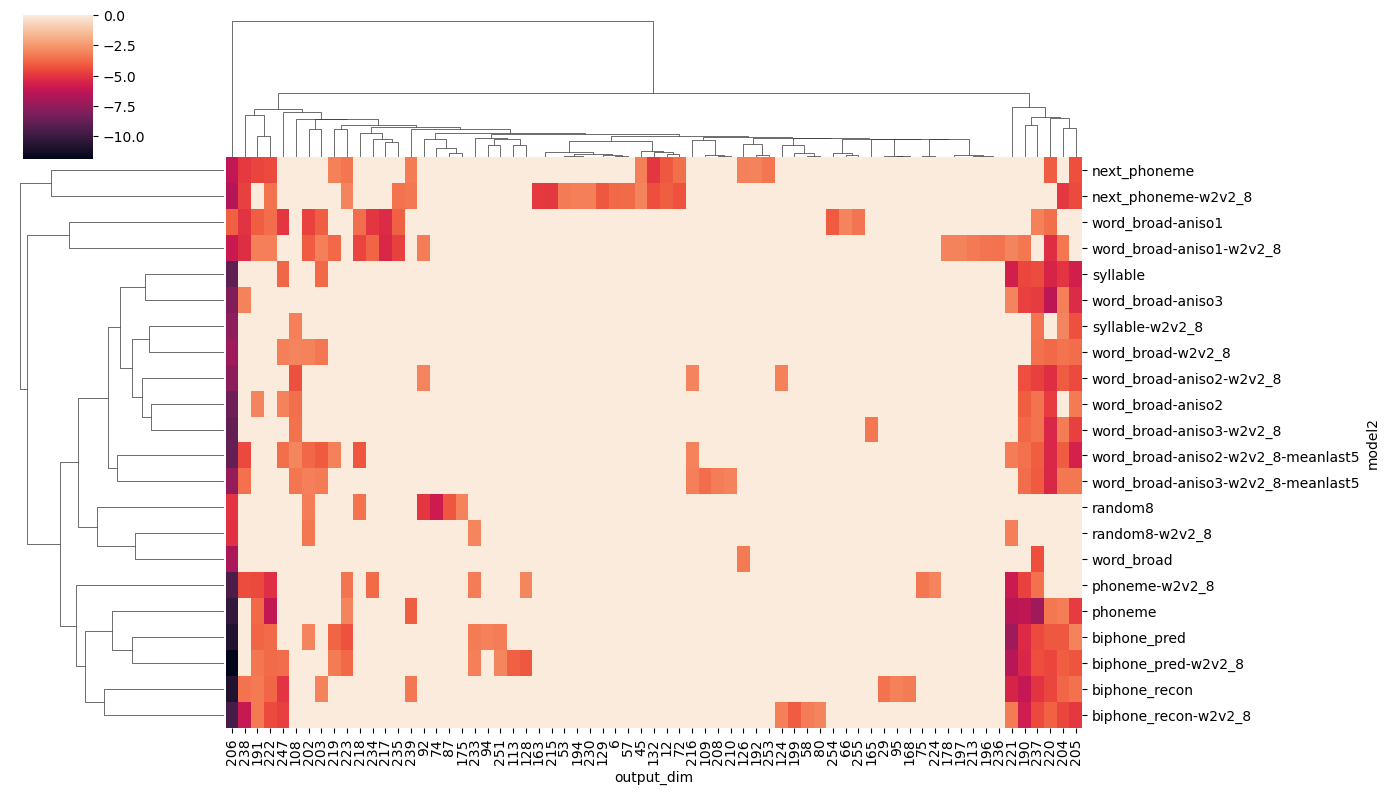

In [30]:
sns.clustermap(log_pvals, vmax=0, xticklabels=1, figsize=(14, 8))

## Colocation

### Colocation of baseline predictiveness and model improvement

In [31]:
score_relationship = scores_df.assign(model=scores_df.model.replace({model_name: "full_model" for model_name in set(scores_df.model) - {"baseline"}})) \
    .reset_index().pivot(index=["model2", "output_dim", "fold"], columns="model", values="score")
score_relationship

model                              baseline  full_model
model2            output_dim fold                      
biphone_pred      0          0    -0.000562   -0.002297
                             1     0.000061   -0.000697
                             2    -0.000027   -0.001133
                  1          0    -0.004349   -0.005191
                             1    -0.001013   -0.001122
...                                     ...         ...
word_broad-w2v2_8 254        1     0.061481    0.059510
                             2     0.047458    0.047299
                  255        0     0.076059    0.077111
                             1     0.055287    0.054907
                             2     0.046627    0.046737

[16896 rows x 2 columns]

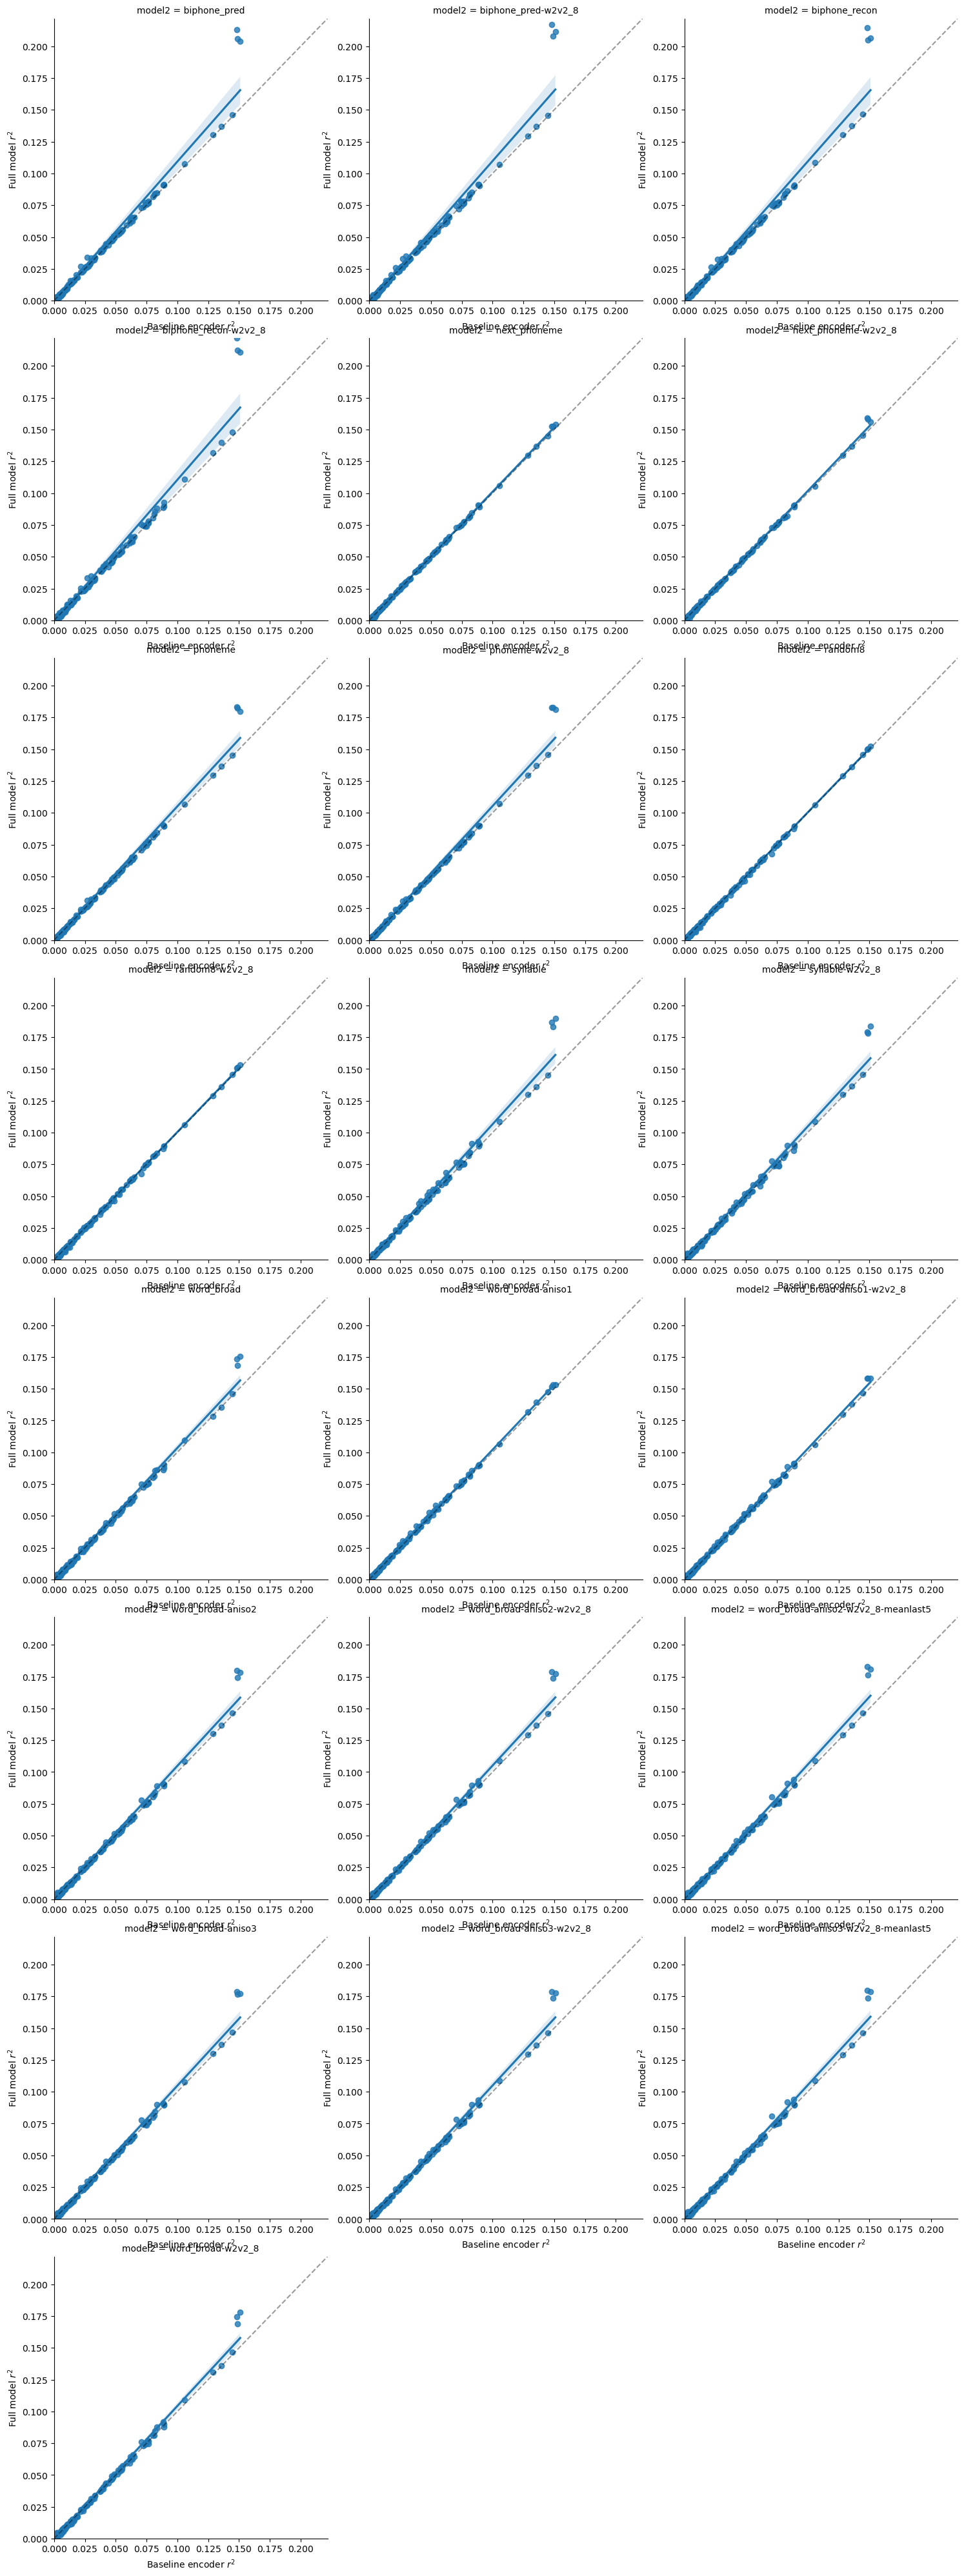

In [32]:
g = sns.lmplot(data=score_relationship.reset_index(), x="baseline", y="full_model", col="model2", col_wrap=3,
               facet_kws=dict(sharex=False, sharey=False))

ax_min = 0.
ax_max = score_relationship.max().max()
for ax in g.axes.ravel():
    ax.plot([0, 1], [0, 1], color="black", linestyle="--", alpha=0.4)
    ax.set_xlim(ax_min, ax_max)
    ax.set_ylim(ax_min, ax_max)
    ax.set_xlabel("Baseline encoder $r^2$")
    ax.set_ylabel("Full model $r^2$")

### Colocation of model embedding and TRF weights

Which electrodes demonstrate simultaneous activation in response to acoustic-phonetic weights and also model embeddings?

In [33]:
study_model = "word_broad"
study_coef = coef_df.loc["baseline"].reset_index().set_index("output_dim")
study_coef["feature_is_phonetic"] = study_coef.feature.isin(phonetic_features)
study_coef["feature_is_prosodic"] = study_coef.feature.isin(("F0", "maxDtL"))
study_coef["base_feature"] = study_coef.feature.str.split("_", expand=True)[0]
study_coef["significantly_predicted"] = False
study_coef.loc[ttest_df.loc[study_model].droplevel("model1").index, "significantly_predicted"] = True

study_coef

model  fold feature output_name  input_dim  lag  time  \
output_dim                                                             
0           baseline     0   onset         FG1          0    0  0.00   
0           baseline     0   onset         FG1          0    1  0.01   
0           baseline     0   onset         FG1          0    2  0.02   
0           baseline     0   onset         FG1          0    3  0.03   
0           baseline     0   onset         FG1          0    4  0.04   
...              ...   ...     ...         ...        ...  ...   ...   
255         baseline     2      F0       TG128         12   56  0.56   
255         baseline     2      F0       TG128         12   57  0.57   
255         baseline     2      F0       TG128         12   58  0.58   
255         baseline     2      F0       TG128         12   59  0.59   
255         baseline     2      F0       TG128         12   60  0.60   

                coef  feature_is_phonetic  feature_is_prosodic base_feature  \
output_dim                                                                    
0           0.000017                False                False        onset   
0           0.000057                False                False        onset   
0          -0.000112                False                False        onset   
0          -0.000082                False                False        onset   
0          -0.000049                False                False        onset   
...              ...                  ...                  ...          ...   
255        -0.001678                False                 True           F0   
255        -0.001754                False                 True           F0   
255        -0.001868                False                 True           F0   
255        -0.002285                False                 True           F0   
255        -0.002988                False                 True           F0   

            significantly_predicted  
output_dim                           
0                             False  
0                             False  
0                             False  
0                             False  
0                             False  
...                             ...  
255                            True  
255                            True  
255                            True  
255                            True  
255                            True  

[609024 rows x 12 columns]

In [34]:
electrode_pvals = ttest_df.loc[(slice(None), "baseline"), "log_pval"].groupby(["model2", "output_dim"]).max()
# insert zero tvalues for missing electrode--model combinations
electrode_pvals = electrode_pvals.reindex(pd.MultiIndex.from_product([ttest_df.index.get_level_values("model2").unique(), study_coef.index.unique()])).fillna(0.)

feature_norms = study_coef.groupby(["base_feature", "output_dim", "fold"]).coef.apply(np.linalg.norm) \
    .groupby(["base_feature", "output_dim"]).mean().to_frame("feature_norm")
norm_study_df = pd.merge(feature_norms, electrode_pvals, left_index=True, right_index=True,
                         how="inner", validate="one_to_many").sort_index()
norm_study_df

feature_norm  \
output_dim base_feature     model2                                             
0          F0               biphone_pred                            0.005660   
                            biphone_pred-w2v2_8                     0.005660   
                            biphone_recon                           0.005660   
                            biphone_recon-w2v2_8                    0.005660   
                            next_phoneme                            0.005660   
...                                                                      ...   
255        phnfeatConsOnset word_broad-aniso2-w2v2_8-meanlast5      0.020909   
                            word_broad-aniso3                       0.020909   
                            word_broad-aniso3-w2v2_8                0.020909   
                            word_broad-aniso3-w2v2_8-meanlast5      0.020909   
                            word_broad-w2v2_8                       0.020909   

                                                                log_pval  
output_dim base_feature     model2                                        
0          F0               biphone_pred                        0.000000  
                            biphone_pred-w2v2_8                 0.000000  
                            biphone_recon                       0.000000  
                            biphone_recon-w2v2_8                0.000000  
                            next_phoneme                        0.000000  
...                                                                  ...  
255        phnfeatConsOnset word_broad-aniso2-w2v2_8-meanlast5  0.000000  
                            word_broad-aniso3                   0.000000  
                            word_broad-aniso3-w2v2_8            0.000000  
                            word_broad-aniso3-w2v2_8-meanlast5  0.000000  
                            word_broad-w2v2_8                  -2.294235  

[28160 rows x 2 columns]

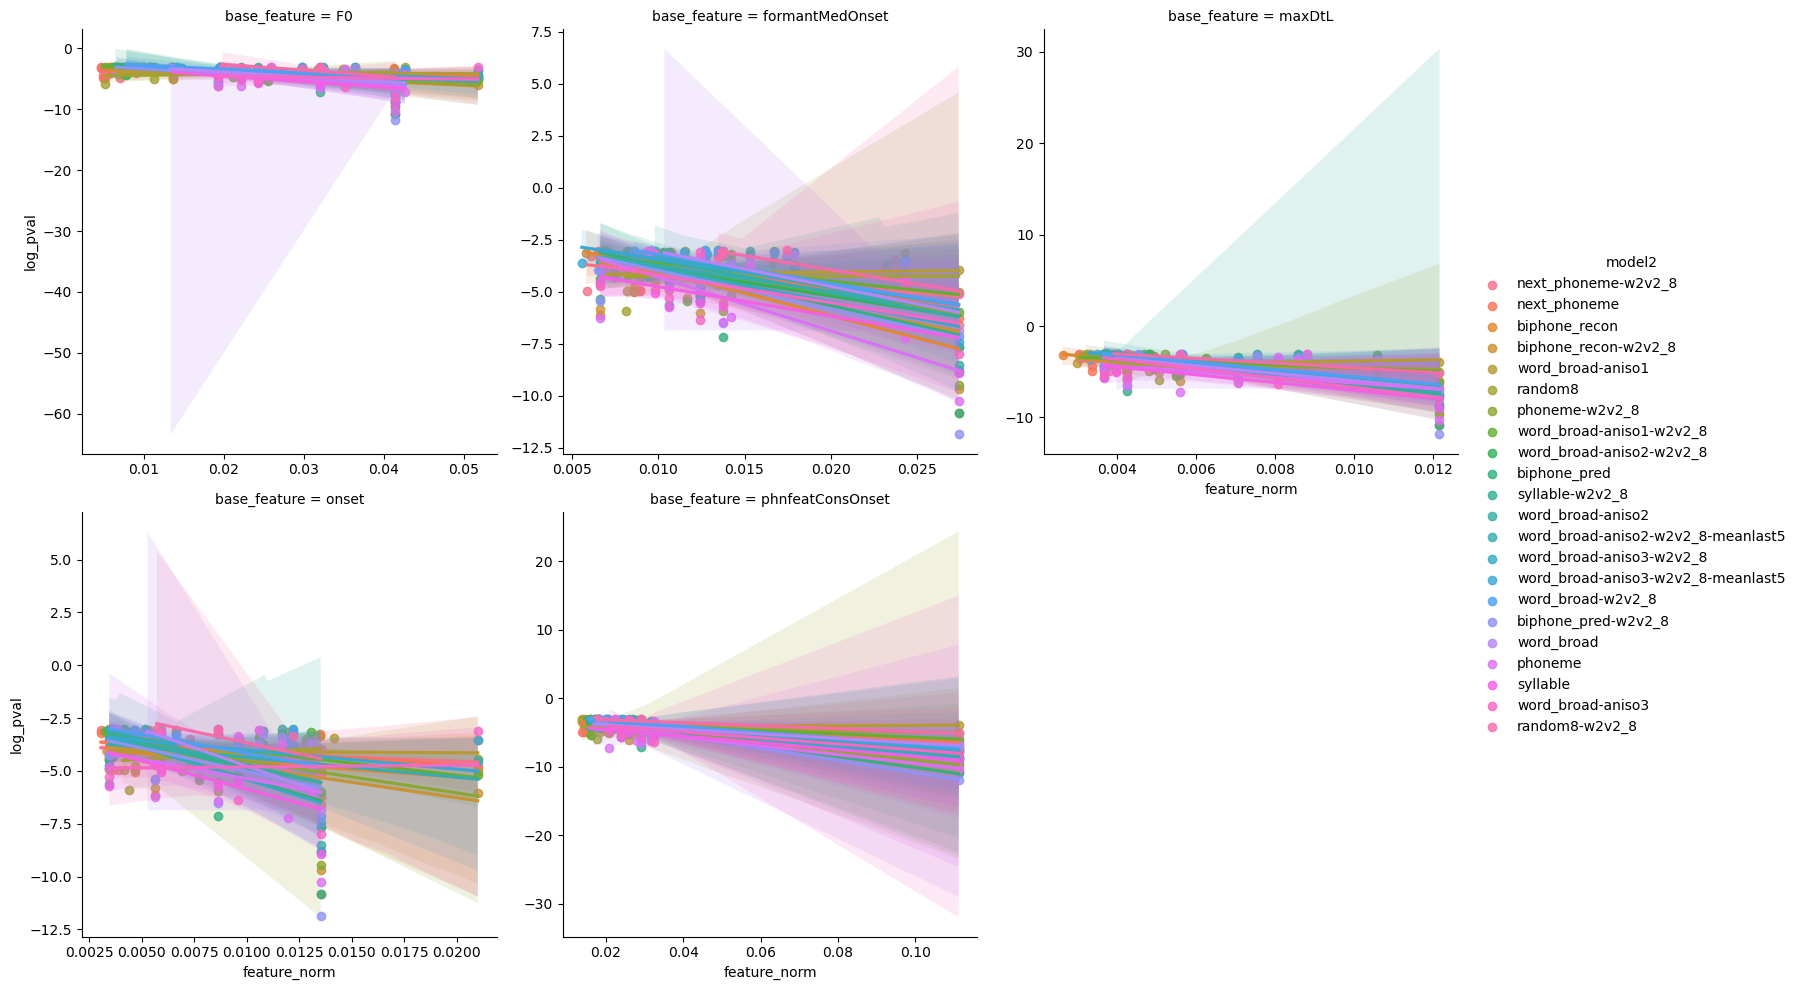

In [35]:
plot_norm_study_df = norm_study_df.reset_index()
plot_norm_study_df = plot_norm_study_df[plot_norm_study_df.log_pval < np.log10(pval_threshold)]
# drop outliers
# tval_max = np.percentile(norm_study_df.tval, 99)
# plot_norm_study_df = plot_norm_study_df[plot_norm_study_df.tval < tval_max]

g = sns.lmplot(data=plot_norm_study_df, x="feature_norm", y="log_pval", col="base_feature",
               hue="model2", facet_kws=dict(sharex=False, sharey=False), col_wrap=3)
# drop outliers
# g.set(ylim=(0, tval_max))

# TODO just look for qualitative examples
# find 2 peakRate-tuned electrodes, one improved by word and one improved by phoneme
# then look at sentence/word/syllable/peakRate-aligned ERPs on e.g. median split of peakRate
# point is to find qualitative link between feature contrast and model comparison

# TODO also look in weight space -- do we see difference in e.g. morphology of ac-phon response vs. morphology of embedding response?
# or look for electrodes which exhibit different magnitudes of evoked response to ac-phon vs embedding in different directions

# These might live in PC20, but show that they emerge from computations on PC1/PC2

In [36]:
plot_norm_study_df[(plot_norm_study_df.base_feature == "maxDtL") & (plot_norm_study_df.log_pval < -3) &
                   (plot_norm_study_df.feature_norm > 0.015)]

Empty DataFrame
Columns: [output_dim, base_feature, model2, feature_norm, log_pval]
Index: []

In [37]:
norm_study_df.loc[([190], "phnfeatConsOnset"), :]

feature_norm  \
output_dim base_feature     model2                                             
190        phnfeatConsOnset biphone_pred                              0.0317   
                            biphone_pred-w2v2_8                       0.0317   
                            biphone_recon                             0.0317   
                            biphone_recon-w2v2_8                      0.0317   
                            next_phoneme                              0.0317   
                            next_phoneme-w2v2_8                       0.0317   
                            phoneme                                   0.0317   
                            phoneme-w2v2_8                            0.0317   
                            random8                                   0.0317   
                            random8-w2v2_8                            0.0317   
                            syllable                                  0.0317   
                            syllable-w2v2_8                           0.0317   
                            word_broad                                0.0317   
                            word_broad-aniso1                         0.0317   
                            word_broad-aniso1-w2v2_8                  0.0317   
                            word_broad-aniso2                         0.0317   
                            word_broad-aniso2-w2v2_8                  0.0317   
                            word_broad-aniso2-w2v2_8-meanlast5        0.0317   
                            word_broad-aniso3                         0.0317   
                            word_broad-aniso3-w2v2_8                  0.0317   
                            word_broad-aniso3-w2v2_8-meanlast5        0.0317   
                            word_broad-w2v2_8                         0.0317   

                                                                log_pval  
output_dim base_feature     model2                                        
190        phnfeatConsOnset biphone_pred                       -5.370031  
                            biphone_pred-w2v2_8                -5.437620  
                            biphone_recon                      -6.120768  
                            biphone_recon-w2v2_8               -5.803858  
                            next_phoneme                       -1.849718  
                            next_phoneme-w2v2_8                -2.496545  
                            phoneme                            -6.257564  
                            phoneme-w2v2_8                     -4.643931  
                            random8                             0.000000  
                            random8-w2v2_8                      0.000000  
                            syllable                           -4.545722  
                            syllable-w2v2_8                    -2.396340  
                            word_broad                         -2.983059  
                            word_broad-aniso1                  -0.892934  
                            word_broad-aniso1-w2v2_8           -3.363188  
                            word_broad-aniso2                  -3.993242  
                            word_broad-aniso2-w2v2_8           -4.362503  
                            word_broad-aniso2-w2v2_8-meanlast5 -3.529182  
                            word_broad-aniso3                  -4.733013  
                            word_broad-aniso3-w2v2_8           -3.793314  
                            word_broad-aniso3-w2v2_8-meanlast5 -3.641454  
                            word_broad-w2v2_8                  -2.655296

In [38]:
electrode_pvals.groupby("output_dim").apply(lambda xs: xs.loc["word_broad"] - xs.loc["biphone_pred"]).sort_values(ascending=False)

output_dim  output_dim
221         221           5.130559
206         206           3.972777
219         219           3.847386
233         233           3.276799
251         251           3.208894
                            ...   
92          92           -1.998351
208         208          -2.157453
79          79           -2.213261
166         166          -2.934267
126         126          -3.321489
Name: log_pval, Length: 256, dtype: float64

In [39]:
feature_norms.loc[(slice(None), [373]), :].sort_values("feature_norm")

KeyError: 373

In [ ]:
study_f0_no_model = norm_study_df.loc[(slice(None), "F0"), :].groupby(["output_dim", "feature_norm"]).log_pval.min().reset_index()
study_f0_no_model = study_f0_no_model[study_f0_no_model.log_pval == 0]
study_f0_no_model.sort_values("feature_norm", ascending=False)

output_dim  feature_norm  log_pval
219         219      0.014885       0.0
1             1      0.010742       0.0
170         170      0.008926       0.0
247         247      0.008131       0.0
16           16      0.008077       0.0
..          ...           ...       ...
300         300      0.004449       0.0
149         149      0.004381       0.0
84           84      0.004230       0.0
131         131      0.003872       0.0
67           67      0.003804       0.0

[63 rows x 3 columns]

In [ ]:
def render_electrode_panel(
        electrode, model_embeddings=None, features=None,
        trial_epoch_kwargs=None,
        word_epoch_kwargs=None,
        word_epoch2_kwargs=None,
        smoke_test=False):
    figure = plt.figure(figsize=(32, 24))
    gs = gridspec.GridSpec(3, 4, figure=figure,
                           width_ratios=[3, 3, 2, 2], hspace=0.25, wspace=0.25)
    electrodes = [electrode]

    errorbar = ("ci", 95) if not smoke_test else None

    if model_embeddings is None:
        model_embeddings = sorted([m for m in electrode_pvals.index.get_level_values("model2").unique() if m != "baseline"])
    if features is None:
        features = sorted([f for f in coef_df.feature.unique() if not f.startswith("model_embedding")])

    ##### plot electrode t-values and feature norms

    tval_ax = figure.add_subplot(gs[0, 0])
    tval_ax.set_title("Improvement log $p$-values by model embedding")
    tval_ax.axvline(np.log10(pval_threshold), color="black", linestyle="--", linewidth=2)
    feature_norm_ax = figure.add_subplot(gs[0, 1])
    feature_norm_ax.set_title("Feature norms")

    tval_df = electrode_pvals.loc[(slice(None), electrodes)]
    tval_df_order = tval_df.sort_values(ascending=True).index.get_level_values("model2")
    sns.barplot(data=tval_df.reset_index(), x="log_pval", y="model2",
                ax=tval_ax, order=tval_df_order)
    for ticklabel in tval_ax.get_yticklabels():
        if ticklabel.get_text() in model_embeddings:
            ticklabel.set_fontweight("bold")

    feature_norm_df = feature_norms.loc[(slice(None), electrodes), :]
    feature_norm_df_order = feature_norm_df.feature_norm.sort_values(ascending=False).index.get_level_values("base_feature")
    sns.barplot(data=feature_norm_df.reset_index(), x="feature_norm", y="base_feature",
                ax=feature_norm_ax, order=feature_norm_df_order)
    for ticklabel in feature_norm_ax.get_yticklabels():
        if ticklabel.get_text().startswith(tuple(features)):
            ticklabel.set_fontweight("bold")

    #####

    # prepare single coefficient df
    plot_coef_df = coef_df.loc[model_embeddings].reset_index()
    # name model embedding coefficients according to model
    model_coefs = plot_coef_df.loc[plot_coef_df.feature.str.startswith("model_embedding")]
    plot_coef_df.loc[plot_coef_df.feature.str.startswith("model_embedding"), "feature"] = \
        model_coefs.model.str.cat(model_coefs.feature, sep="_")

    # filter to electrodes of interest
    plot_coef_df = plot_coef_df[plot_coef_df.output_dim.isin(electrodes)]
    # filter to features of interest
    plot_coef_df_features = plot_coef_df[plot_coef_df.feature.str.startswith(tuple(features))]
    plot_coef_df_features = plot_coef_df_features[["fold", "feature", "output_dim", "time", "coef"]]
    plot_coef_df_features["type"] = "basic_feature"
    # add computed feature norms for embeddings
    plot_coef_df_embeddings = plot_coef_df[plot_coef_df.feature.str.contains("model_embedding")]
    plot_coef_df_embeddings = plot_coef_df_embeddings.groupby(["fold", "model", "output_dim", "time"]) \
        .coef.apply(lambda xs: xs.abs().sum()).reset_index() \
        .rename(columns={"model": "feature"}).assign(type="model_embedding")
    # add computed feature norms for embeddings
    plot_coef_subset_df = pd.concat([
        plot_coef_df_features,
        plot_coef_df_embeddings
    ])
    
    #####
    # coef_line_ax = figure.add_subplot(gs[1, :])
    # sns.lineplot(data=plot_coef_subset_df, x="time", y="coef", hue="feature", style="type", ax=coef_line_ax)

    #####

    feature_coef_heatmap_ax = figure.add_subplot(gs[1, :2])
    plot_coef_heatmap_df = plot_coef_df_features.pivot_table(
        index="feature", columns="time", values="coef", aggfunc="mean")
    plot_coef_heatmap_df = plot_coef_heatmap_df.loc[sorted(plot_coef_df_features.feature.unique())]
    sns.heatmap(plot_coef_heatmap_df, ax=feature_coef_heatmap_ax, cmap="RdBu", center=0, yticklabels=True)

    model_coef_heatmap_ax = figure.add_subplot(gs[2, :2])
    plot_coef_heatmap_df = plot_coef_df_embeddings.pivot_table(
        index="feature", columns="time", values="coef", aggfunc="mean")
    # # order by decreasing t-value
    # plot_coef_heatmap_df = plot_coef_heatmap_df.loc[[model for model in tval_df_order if model in plot_coef_heatmap_df.index]]
    # order by name
    plot_coef_heatmap_df = plot_coef_heatmap_df.loc[sorted(plot_coef_df_embeddings.feature.unique())]
    sns.heatmap(plot_coef_heatmap_df, ax=model_coef_heatmap_ax, cmap="RdBu", center=0, yticklabels=True)

    #####

    trial_epochs_ax = figure.add_subplot(gs[0, 2])
    trial_epochs_ax.set_title("Trial ERP")
    trial_epochs_ax.axvline(0, color="gray", linestyle="--")
    plot_trial_epochs = trial_epochs[(trial_epochs.electrode_idx == electrode)]
    sns.lineplot(data=plot_trial_epochs, x="epoch_time", y="value", ax=trial_epochs_ax,
                 errorbar=errorbar,
                 **(trial_epoch_kwargs or {}))

    word_epochs_ax = figure.add_subplot(gs[1, 2])
    word_epochs_ax.set_title("Word ERP")
    word_epochs_ax.axvline(0, color="gray", linestyle="--")
    plot_word_epochs = word_epochs[word_epochs.electrode_idx == electrode]
    sns.lineplot(data=plot_word_epochs, x="epoch_time", y="value", ax=word_epochs_ax,
                 errorbar=errorbar,
                 **(word_epoch_kwargs or {}))
    
    word_epochs2_ax = figure.add_subplot(gs[2, 2])
    word_epochs2_ax.set_title("Word ERP")
    word_epochs2_ax.axvline(0, color="gray", linestyle="--")
    plot_word_epochs2 = word_epochs[word_epochs.electrode_idx == electrode]
    sns.lineplot(data=plot_word_epochs2, x="epoch_time", y="value", ax=word_epochs2_ax,
                 errorbar=errorbar,
                 **(word_epoch2_kwargs or {}))

    syllable_epochs_ax = figure.add_subplot(gs[0, 3])
    syllable_epochs_ax.set_title("Syllable ERP")
    syllable_epochs_ax.axvline(0, color="gray", linestyle="--")
    plot_syllable_epochs = syllable_epochs[syllable_epochs.electrode_idx == electrode]
    sns.lineplot(data=plot_syllable_epochs, x="epoch_time", y="value", ax=syllable_epochs_ax,
                 errorbar=errorbar)

    plt.suptitle(f"Electrode {electrode} study")
    plt.tight_layout()
    
    return plot_coef_df

In [ ]:
# electrodes tuned to matched features and different models
panel_electrodes = [231, 205, 373, 173, 214, 123]
# electrodes tuned to F0 but not to models
panel_electrodes += [212, 33, 219, 193]

In [ ]:
for electrode in tqdm(panel_electrodes):
    with plt.rc_context(rc={"font.size": 18}):
        render_electrode_panel(
            electrode,
            word_epoch_kwargs=dict(hue="monosyllabic"),
            word_epoch2_kwargs=dict(hue="word_frequency_quantile"))
        f = plt.gcf()
        f.savefig(f"electrode_panel_{electrode}.png")
        f.clf()

  0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_3476946/1171676103.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_3476946/1171676103.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_3476946/1171676103.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_3476946/1171676103.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_3476946/1171676103.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_3476946/1171676103.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layo

Text(33.722222222222214, 0.5, 'Baseline $r^2$')

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/categorical.py:3370: UserWarning: 66.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


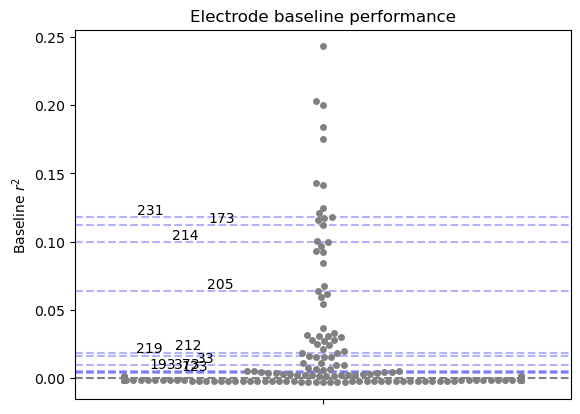

In [ ]:
baseline_mean_scores = baseline_scores.groupby("output_dim").score.mean()
ax = sns.swarmplot(baseline_mean_scores, color="gray")
ax.axhline(0, color="gray", linestyle="--")

for elec, score in baseline_mean_scores.loc[panel_electrodes].items():
    ax.text(0.2 + np.random.normal(0, 0.1), score, elec, ha="center", va="bottom",
            transform=transforms.blended_transform_factory(ax.transAxes, ax.transData))
    ax.axhline(score, color="blue", linestyle="--", alpha=0.3)

ax.set_title("Electrode baseline performance")
ax.set_ylabel("Baseline $r^2$")

In [ ]:
with plt.rc_context(rc={"font.size": 18}):
    g = sns.clustermap(ttest_df.loc[:, :, panel_electrodes].dropna().groupby(["model2", "model1", "output_dim"]).log_pval.max().reset_index() \
                    .pivot(index="output_dim", columns="model2", values="log_pval").fillna(0),
                cmap="viridis", figsize=(14, 8))
    g.ax_heatmap.set_title("Electrode model comparison $p$-values")

KeyError: 219

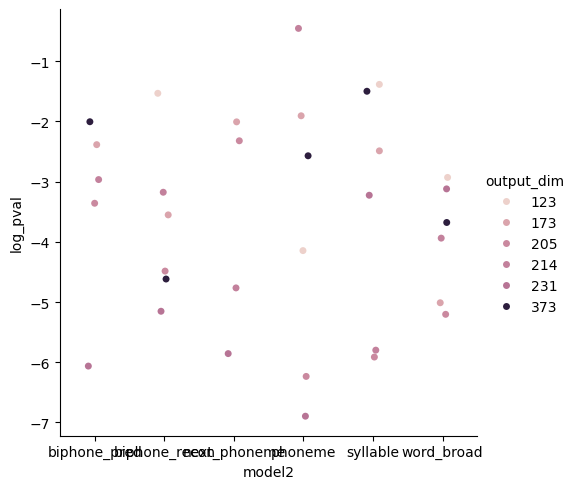

In [ ]:
sns.catplot(data=ttest_df.loc[:, :, panel_electrodes].dropna().groupby(["model2", "model1", "output_dim"]).log_pval.max().reset_index(),
            x="output_dim", y="log_pval", hue="output_dim")

In [ ]:
baseline_mean_scores.loc[panel_electrodes]

output_dim
231    0.117821
205    0.063889
373    0.004987
173    0.111884
214    0.099354
123    0.003638
Name: score, dtype: float64

In [ ]:
snapshot.all_state_spaces["word"].cuts.loc["bricks"]

description  onset_frame_idx  offset_frame_idx  \
instance_idx level                                                           
0            phoneme                  B           803502            803504   
             phoneme                  R           803504            803506   
             phoneme                 IH           803506            803510   
             phoneme                  K           803510            803514   
             phoneme                  S           803514            803518   
             syllable  (B, R, IH, K, S)           803502            803518   

                       item_idx  
instance_idx level               
0            phoneme       5252  
             phoneme       5252  
             phoneme       5252  
             phoneme       5252  
             phoneme       5252  
             syllable      5252

In [ ]:
word_epochs

epoch_idx  electrode_idx epoch_sample     value epoch_time  \
0                 0              0            0  0.708037       -0.1   
1                 0              1            0 -0.636341       -0.1   
2                 0              2            0 -0.015292       -0.1   
3                 0              3            0 -0.106601       -0.1   
4                 0              4            0 -0.503995       -0.1   
...             ...            ...          ...       ...        ...   
54959995       2999            453           39 -0.067755       0.29   
54959996       2999            454           39  1.562028       0.29   
54959997       2999            455           39  0.992946       0.29   
54959998       2999            456           39  0.844829       0.29   
54959999       2999            457           39  0.399839       0.29   

         epoch_label  epoch_duration_samples          name  item_idx  \
0             bricks                      40  fadg0_si1279      5252   
1             bricks                      40  fadg0_si1279      5252   
2             bricks                      40  fadg0_si1279      5252   
3             bricks                      40  fadg0_si1279      5252   
4             bricks                      40  fadg0_si1279      5252   
...              ...                     ...           ...       ...   
54959995  feverishly                      40  mzmb0_si1796      1133   
54959996  feverishly                      40  mzmb0_si1796      1133   
54959997  feverishly                      40  mzmb0_si1796      1133   
54959998  feverishly                      40  mzmb0_si1796      1133   
54959999  feverishly                      40  mzmb0_si1796      1133   

          trial_idx state_space  label_idx  instance_idx  \
0                 0        word       5497             0   
1                 0        word       5497             0   
2                 0        word       5497             0   
3                 0        word       5497             0   
4                 0        word       5497             0   
...             ...         ...        ...           ...   
54959995        498        word       2392             0   
54959996        498        word       2392             0   
54959997        498        word       2392             0   
54959998        498        word       2392             0   
54959999        498        word       2392             0   

                                       span_secs span_model_frames  \
0                (0.121175, 0.44430833333333336)           (6, 22)   
1                (0.121175, 0.44430833333333336)           (6, 22)   
2                (0.121175, 0.44430833333333336)           (6, 22)   
3                (0.121175, 0.44430833333333336)           (6, 22)   
4                (0.121175, 0.44430833333333336)           (6, 22)   
...                                          ...               ...   
54959995  (1.047457894736842, 1.732334210526316)          (52, 86)   
54959996  (1.047457894736842, 1.732334210526316)          (52, 86)   
54959997  (1.047457894736842, 1.732334210526316)          (52, 86)   
54959998  (1.047457894736842, 1.732334210526316)          (52, 86)   
54959999  (1.047457894736842, 1.732334210526316)          (52, 86)   

         span_ecog_samples span_ecog_samples_nopad  item_start_frame  \
0                 (62, 94)                (12, 44)            803496   
1                 (62, 94)                (12, 44)            803496   
2                 (62, 94)                (12, 44)            803496   
3                 (62, 94)                (12, 44)            803496   
4                 (62, 94)                (12, 44)            803496   
...                    ...                     ...               ...   
54959995        (154, 223)              (104, 173)            170494   
54959996        (154, 223)              (104, 173)            170494   
54959997        (154, 223)              (104, 173)            170494  

In [ ]:
ttest_filtered_df.loc[(slice(None), panel_electrodes), :].reset_index().set_index(["output_dim", "model2"]).sort_index()

Unnamed: 4 permutation       tval          pval  \
output_dim model2                                                           
123        phoneme                24       shift  16.920203  7.152914e-05   
173        biphone_recon          21       shift  11.955090  2.805105e-04   
           word_broad             11       units  27.963597  9.729389e-06   
205        biphone_pred           24       shift  10.666052  4.376286e-04   
           biphone_recon          15       shift  20.619528  3.267812e-05   
           phoneme                 6       shift  56.654666  5.811751e-07   
           syllable                7       shift  47.067152  1.218916e-06   
           word_broad              8       shift  31.249196  6.249377e-06   
214        biphone_recon          28       shift   9.566699  6.669787e-04   
           next_phoneme            4       shift  24.244899  1.716960e-05   
           syllable                9       units  44.055965  1.587238e-06   
           word_broad             24       shift  14.994255  1.152610e-04   
231        biphone_pred            8       shift  51.318364  8.629020e-07   
           biphone_recon           9       shift  30.342114  7.027965e-06   
           next_phoneme            1       shift  45.539989  1.390544e-06   
           phoneme                 4       shift  82.908127  1.268650e-07   
           syllable               40       units   9.854633  5.947699e-04   
           word_broad             34       units   9.253866  7.581981e-04   
373        biphone_recon          14       shift  22.258354  2.411891e-05   
           word_broad             27       units  12.877002  2.097153e-04   

                          log_pval  
output_dim model2                   
123        phoneme       -4.145517  
173        biphone_recon -3.552051  
           word_broad    -5.011914  
205        biphone_pred  -3.358894  
           biphone_recon -4.485743  
           phoneme       -6.235693  
           syllable      -5.914026  
           word_broad    -5.204163  
214        biphone_recon -3.175888  
           next_phoneme  -4.765240  
           syllable      -5.799358  
           word_broad    -3.938318  
231        biphone_pred  -6.064039  
           biphone_recon -5.153170  
           next_phoneme  -5.856815  
           phoneme       -6.896658  
           syllable      -3.225651  
           word_broad    -3.120217  
373        biphone_recon -4.617642  
           word_broad    -3.678370

In [ ]:
feature_norms_phonetic = study_coef.groupby(["feature", "output_dim", "feature_is_phonetic", "significantly_predicted"]).coef.apply(np.linalg.norm).to_frame("coef").reset_index()
# sns.barplot(x="feature_is_phonetic", y="coef", hue="significantly_predicted", data=feature_norms_phonetic)

<Axes: xlabel='time', ylabel='coef'>

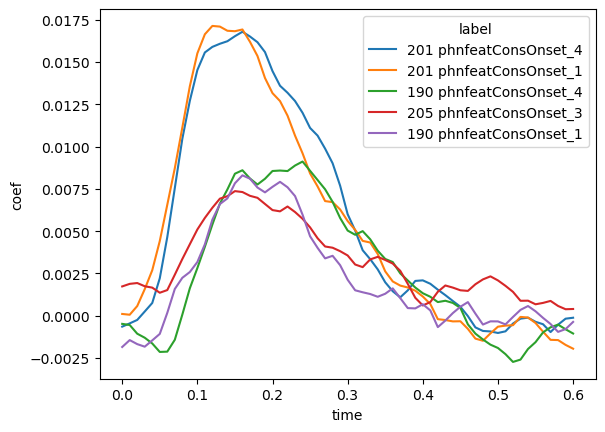

In [ ]:
# Find largest-norm phonetic responses
plot_n = 5
max_norm_phonetic_responses = feature_norms_phonetic[feature_norms_phonetic.feature_is_phonetic == True].sort_values("coef", ascending=False).set_index(["output_dim", "feature"]).head(plot_n).index
plot_df = study_coef.set_index("feature", append=True).loc[max_norm_phonetic_responses].reset_index()
plot_df["label"] = plot_df.output_dim.astype(str) + " " + plot_df.feature
sns.lineplot(data=plot_df, x="time", y="coef", hue="label")

### Colocation of model embedding and onset electrodes

In [ ]:
onset_coef_norm = study_coef[study_coef.feature == "onset"].groupby("output_dim") \
    .coef.apply(np.linalg.norm).sort_values(ascending=False)


/tmp/ipykernel_1754560/2648713857.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_epochs["electrode_idx"] = plot_epochs.electrode_idx.astype(str)


<Axes: xlabel='epoch_time', ylabel='value'>

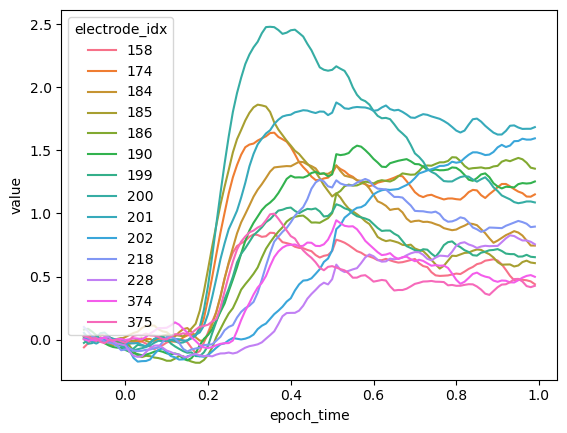

In [ ]:
norm_threshold = 0.009
plot_epochs = trial_epochs[trial_epochs.electrode_idx.isin(onset_coef_norm[onset_coef_norm > norm_threshold].index)]
plot_epochs["electrode_idx"] = plot_epochs.electrode_idx.astype(str)
sns.lineplot(data=plot_epochs,
             x="epoch_time", y="value", hue="electrode_idx", errorbar=None)

In [ ]:
# TODO ask across subject: does model embedding norm predict onset-like response or not?

In [ ]:
embedding_coef_norms = coef_df[coef_df.feature.str.startswith("model_embedding")] \
    .groupby(["model", "output_dim", "feature"]).coef.apply(np.linalg.norm) \
    .groupby(["model", "output_dim"]).mean()
onset_embedding_coef_norms = pd.merge(
    onset_coef_norm, embedding_coef_norms, left_index=True, right_index=True,
    suffixes=("_onset", "_embedding"))
onset_embedding_coef_norms

coef_onset  coef_embedding
model        output_dim                            
biphone_pred 0             0.004365        0.004765
             1             0.003818        0.004052
             2             0.002792        0.003892
             3             0.003488        0.003821
             4             0.003857        0.003661
...                             ...             ...
word_broad   379           0.002618        0.002522
             380           0.003286        0.002754
             381           0.003445        0.003202
             382           0.003590        0.002902
             383           0.002325        0.002572

[2688 rows x 2 columns]

<Axes: xlabel='coef_onset', ylabel='coef_embedding'>

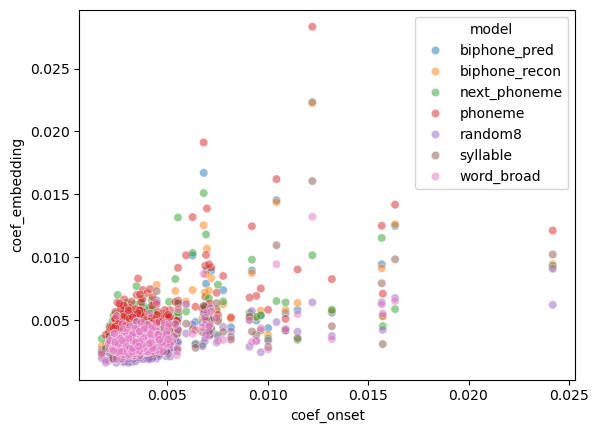

In [ ]:
sns.scatterplot(data=onset_embedding_coef_norms.reset_index(),
                x="coef_onset", y="coef_embedding", hue="model",
                alpha=0.5)

In [ ]:
onset_emb_correlations = onset_embedding_coef_norms \
    .groupby("model").apply(lambda df: pd.Series(spearmanr(df.coef_onset, df.coef_embedding), index=["rho", "pval"])) \
    .sort_values("rho")
onset_emb_correlations

rho          pval
model                                
next_phoneme   0.279621  2.502162e-08
word_broad     0.353505  9.580770e-13
syllable       0.394916  8.783515e-16
biphone_recon  0.413294  2.829718e-17
phoneme        0.430619  9.094437e-19
random8        0.435538  3.303479e-19
biphone_pred   0.468962  2.155644e-22

## ERPs for top-explained electrodes

In [ ]:
def plot_epochs(epochs_df, facet_kwargs=None, col_order="peak_value"):
    if col_order == "peak_value":
        # Order columns by peak mean value
        col_order = epochs_df.groupby(["electrode_idx", "epoch_sample"]) \
            .value.mean().abs().groupby("electrode_idx").max() \
            .sort_values(ascending=False).index
    elif isinstance(col_order, (list, tuple)):
        assert set(col_order) <= set(epochs_df.electrode_idx.unique())
        col_order = col_order
    else:
        raise ValueError(f"Unrecognized col_order: {col_order}")

    g = sns.relplot(data=epochs_df,
                    x="epoch_time", y="value", col="electrode_idx",
                    col_wrap=3, col_order=col_order, kind="line",
                    facet_kws={"sharex": False}, **(facet_kwargs or {}))

    # standard y-position for each model
    model_rect_size = 0.05
    get_model_position = lambda model_name: 0.1 + model_rect_size * sorted(encoder_names).index(model_name)

    for ax, electrode_idx in zip(g.axes.ravel(), col_order):
        ax.axvline(0, color="gray", linestyle="--")
        ax.axhline(0, color="gray", linestyle="--")

        # which models show significant prediction of this electrode?
        for model_name, log_pval_i in log_pvals[electrode_idx].items():
            alpha = 0.05 if log_pval_i == 0 else 0.8
            rect = plt.Rectangle((0.05, get_model_position(model_name)), model_rect_size, model_rect_size,
                                  color=get_model_color(model_name), alpha=alpha, transform=ax.transAxes)
            
            if log_pval_i != 0:
                # annotate with score
                ax.text(0.12, get_model_position(model_name), f"{np.power(10, log_pval_i):.1g}",
                        verticalalignment="bottom", alpha=0.8,
                        transform=ax.transAxes)
            ax.add_patch(rect)
            
    # add a model legend above the top of the facet grid
    legend_ax = g.fig.add_axes([0.1, 1.0, 0.8, 0.05])
    legend_ax.axis("off")
    for model_name in encoder_names:
        legend_ax.add_patch(plt.Rectangle((0.75 * model_rect_size, get_model_position(model_name)), model_rect_size, model_rect_size,
                                        color=get_model_color(model_name), alpha=0.8, transform=legend_ax.transAxes))
        legend_ax.text(0.1, get_model_position(model_name), model_name, verticalalignment="bottom",
                    transform=legend_ax.transAxes)
        
    return g

### Trial onset ERP for top-explained electrodes

In [ ]:
plot_epoch_electrodes = ttest_filtered_df.loc["word_broad"].sort_values("pval") \
    .index.get_level_values("output_dim").unique().to_list()
plot_trial_epochs = trial_epochs[trial_epochs.electrode_idx.isin(plot_epoch_electrodes)]

  0%|          | 0/12 [00:00<?, ?it/s]

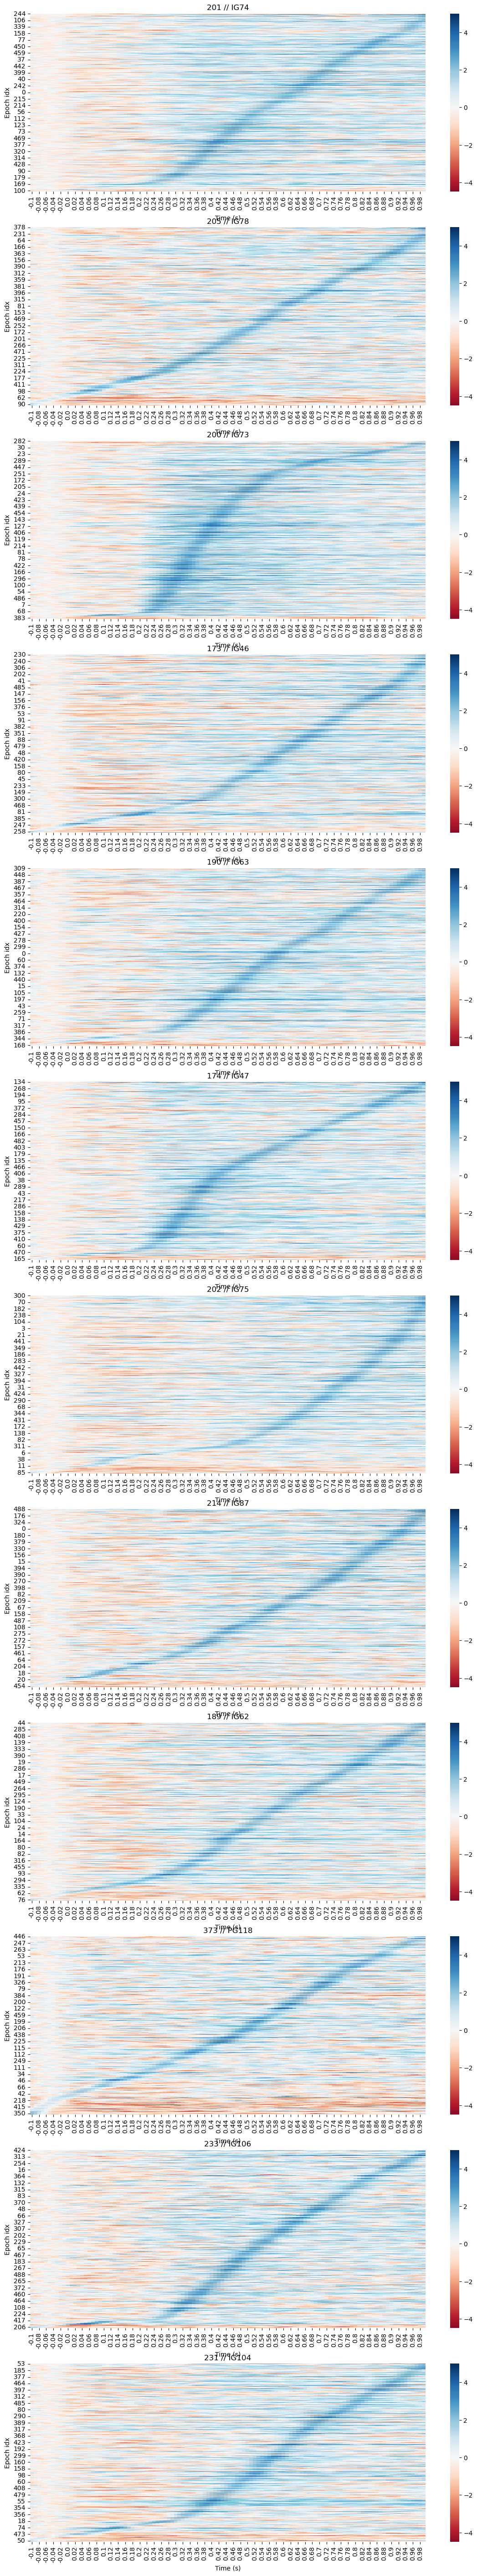

In [ ]:
plot_epoch_raster(plot_trial_epochs, electrode_df,
                  order=plot_epoch_electrodes)
# TODO sort each trial by single-trial predictivity under model
    # what proportion of trials are actually well explained by model embedding?
    # do raw HGA responses look similar for these trials? & compare to other trials
        # e.g. similarly timed peaks

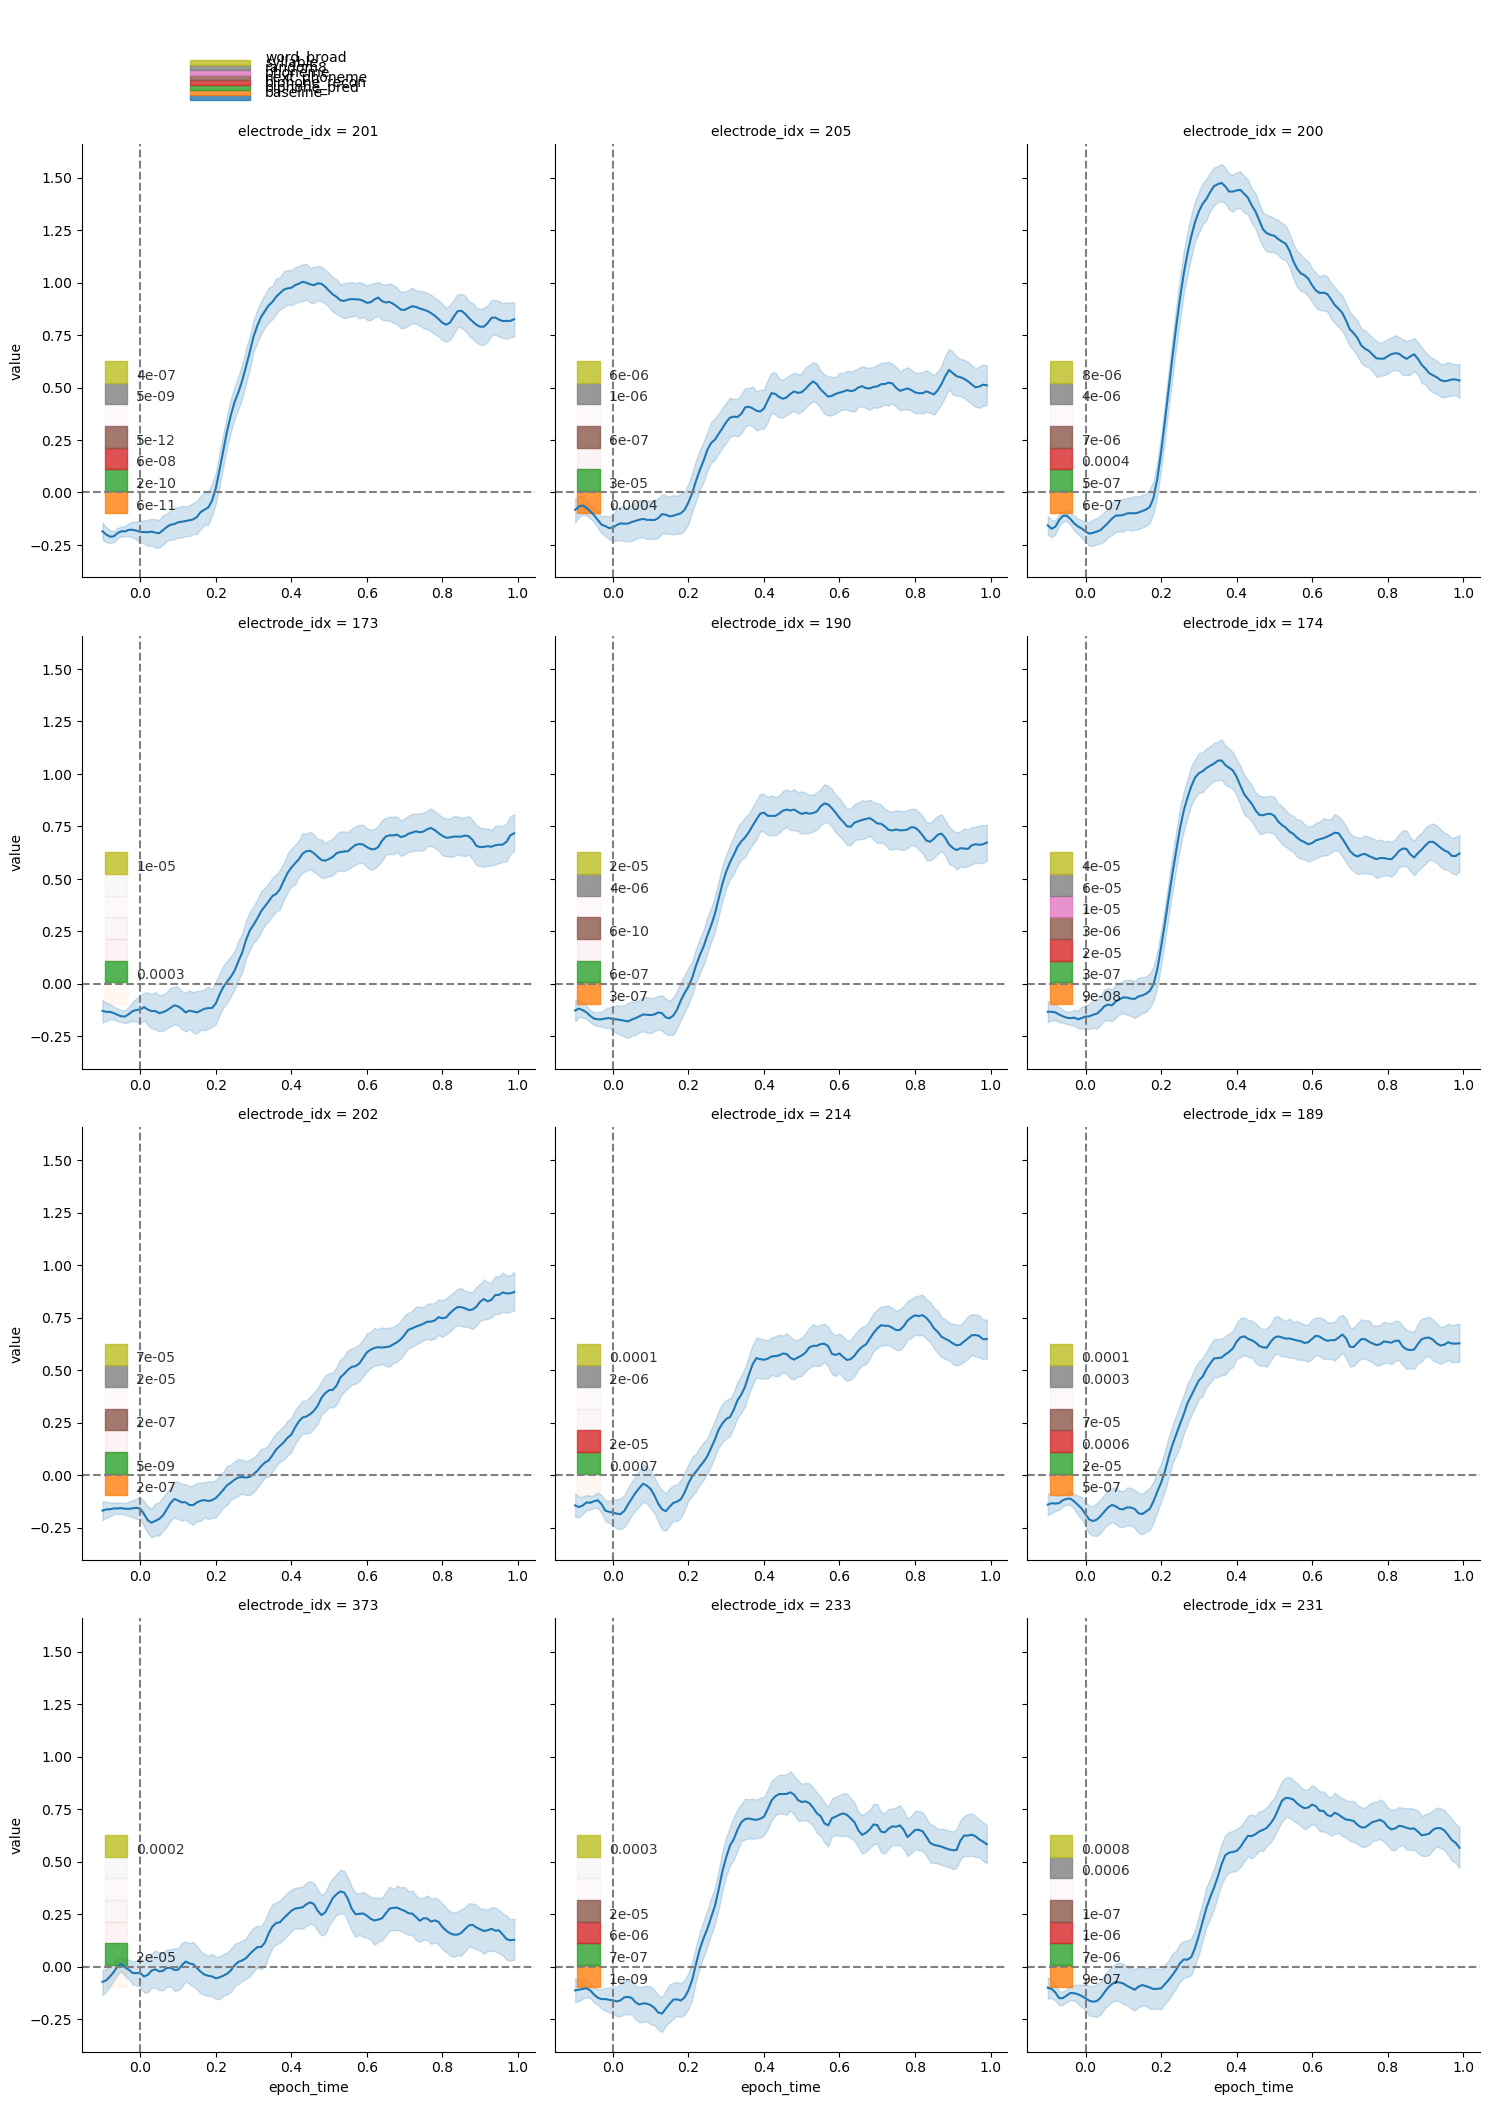

In [ ]:
plot_epochs(plot_trial_epochs, col_order=plot_epoch_electrodes)

### Word onset ERP for top-explained electrodes

  0%|          | 0/3052 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

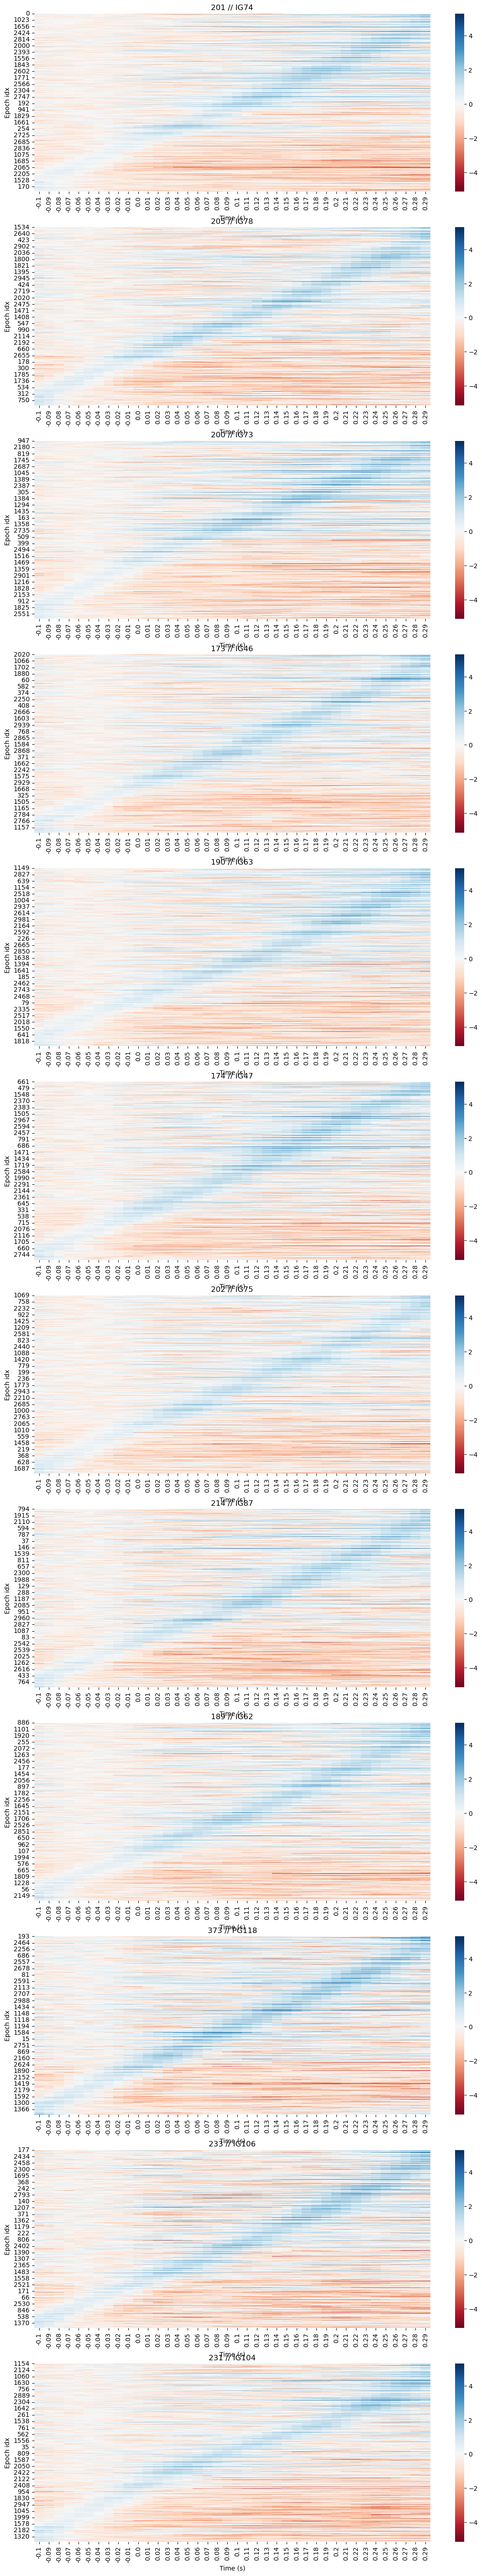

In [ ]:
plot_epoch_raster(word_epochs, electrode_df, order=plot_epoch_electrodes)

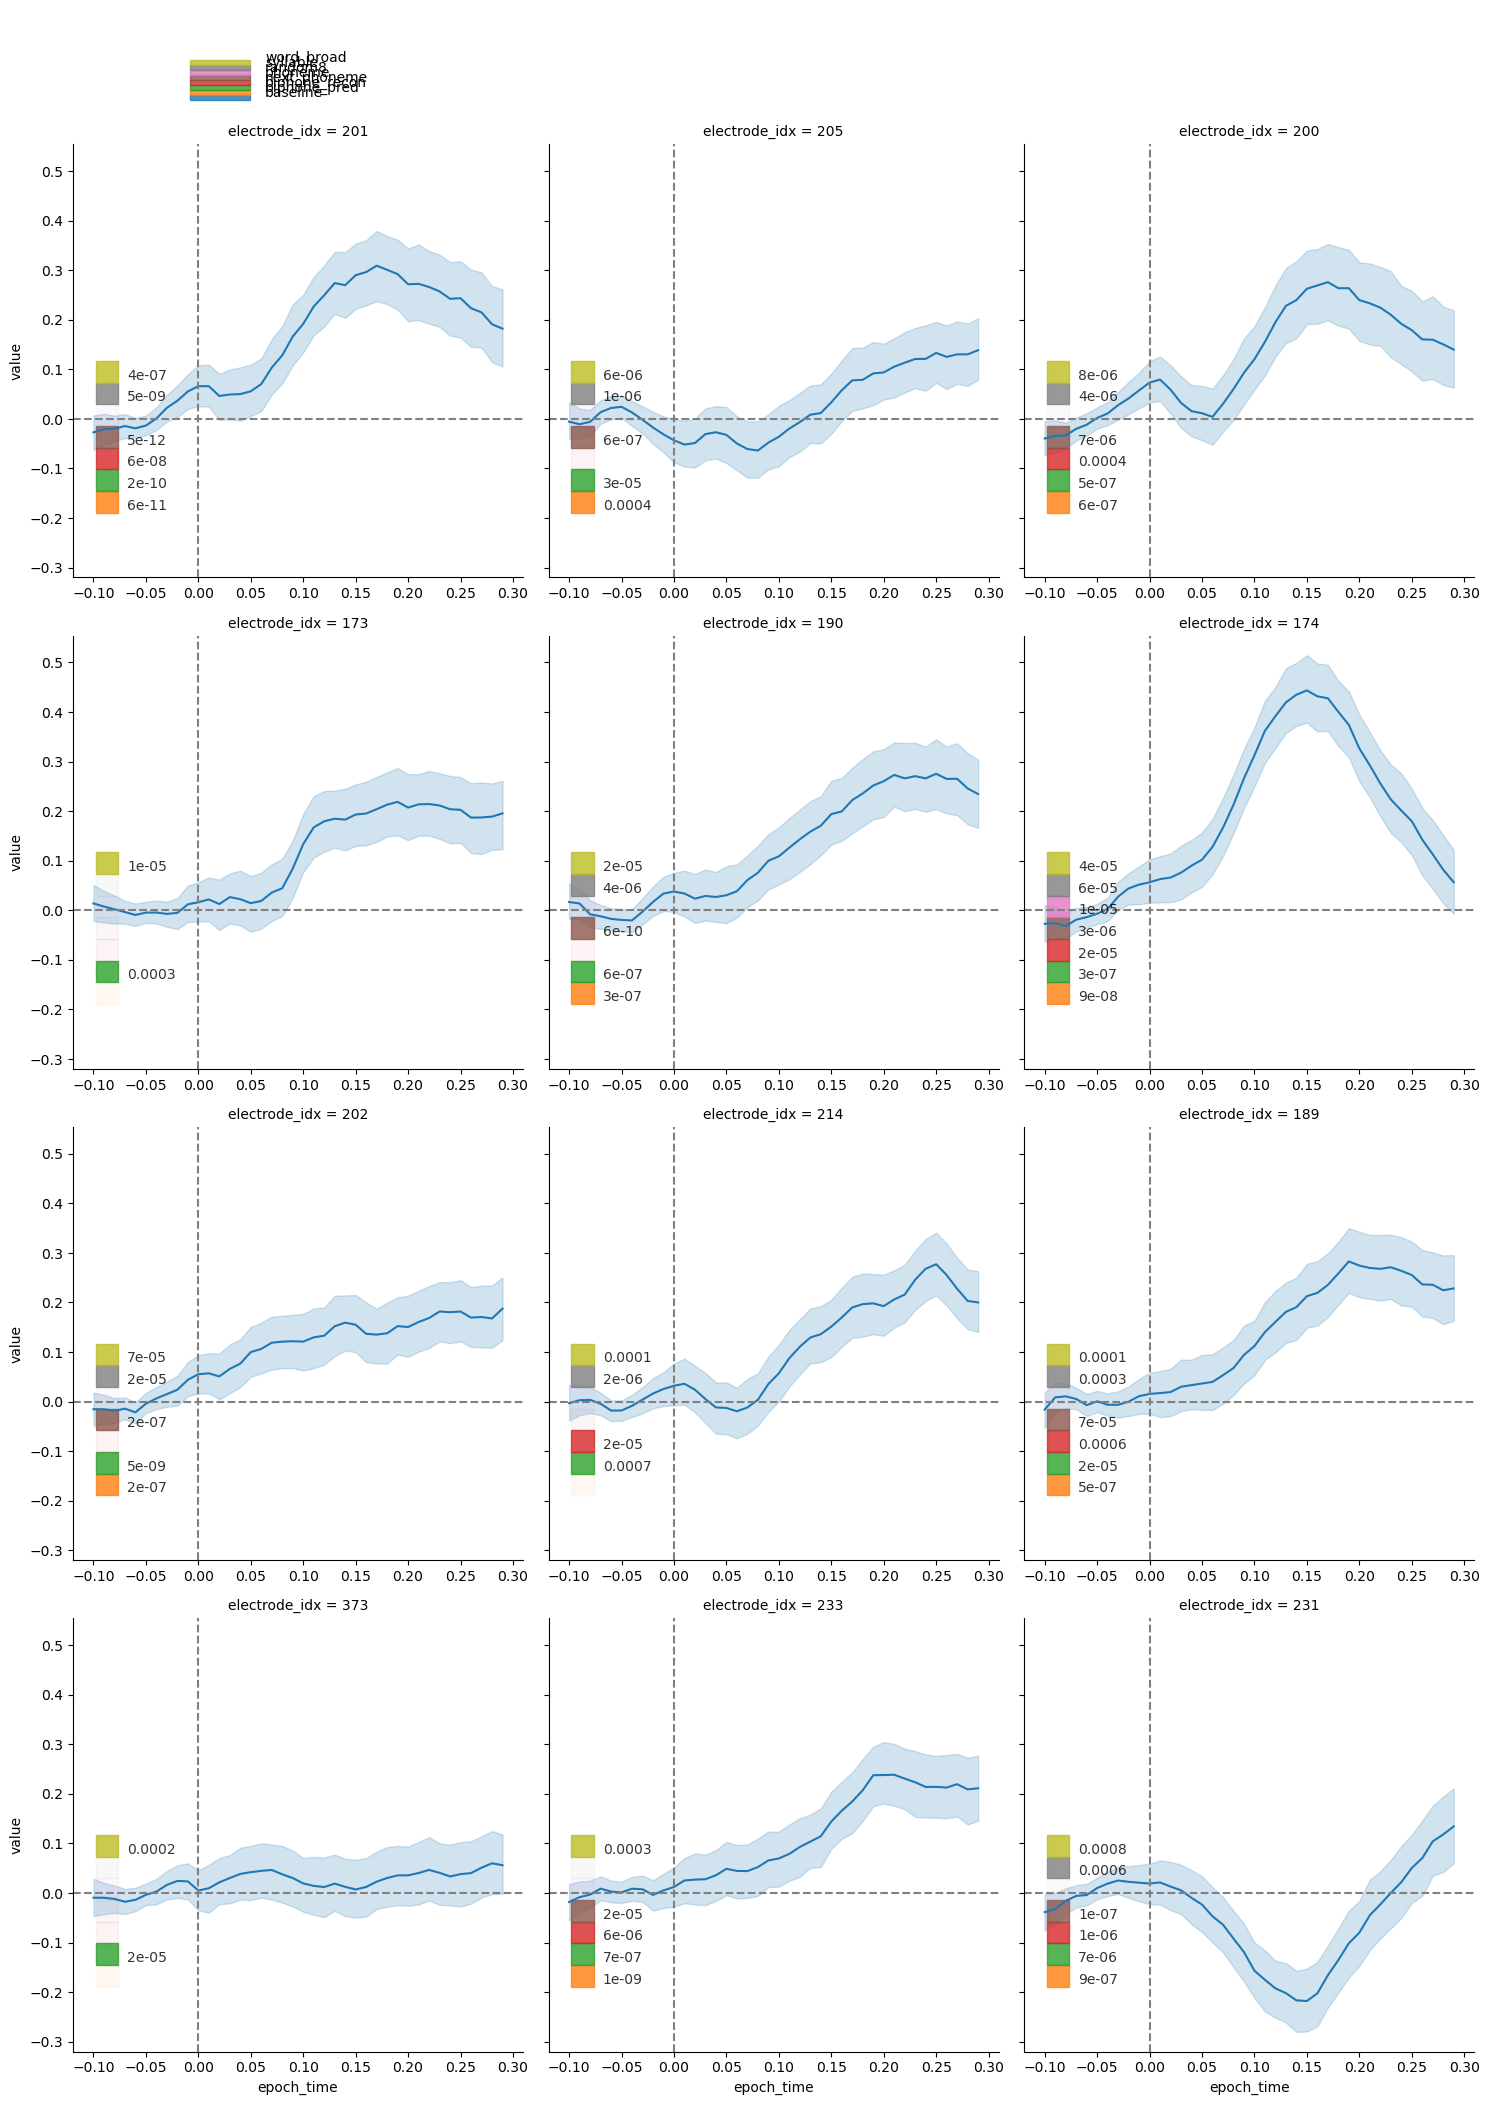

In [ ]:
plot_epochs(word_epochs, col_order=plot_epoch_electrodes)
# TODO add hue by well motivated contrasts between words, break up those error regions into meaningful contrasts